In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import tensorflow.keras.layers as ly
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
train_b = False
model_name = 'test_model_slope_with_solar_weather_future_100_HWC.h5'

In [ ]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])*float(y_test[i]-y_pred[i]) for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RRMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    n = [float(y_test[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/sum(n))        
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Merged"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [ ]:
data =  pd.read_csv(f"{DATA_DIR}/full_merge_v3.csv")
print(data.head(10).to_string())
df_t = pd.to_datetime(data['Time Stamp'])

future_var = ['Dni','HourlyDryBulbTemperature']
for c in future_var:
  data[c+" Future"] = data[c].shift(-forecast_window).backfill()

used_var = ['N.Y.C.','Dni','HourlyDryBulbTemperature','Dni Future','HourlyDryBulbTemperature Future']
data = data[used_var].backfill();
data = data.dropna(how='any')

for c in used_var:
  #print(data[c].head(15));
  print(c,len(data[c].index),data[c].mean(),data[c].std())

print(data.head(5).to_string())
n = len(data.index)
t = int(365*24*(60/5))
num_var = len(used_var)

   Unnamed: 0           Time Stamp  CAPITL  CENTRL  DUNWOD  GENESE  HUD VL  LONGIL  MHK VL  MILLWD  N.Y.C.  NORTH    WEST     NYCA             datetime  year  month  day  hour  minute  dow_x             PeriodEnd           PeriodStart Period  AirTemp  Azimuth  CloudOpacity  DewpointTemp  Dhi  Dni  Ebh  Ghi  GtiFixedTilt  GtiTracking  PrecipitableWater  RelativeHumidity  SnowWater  SurfacePressure  WindDirection10m  WindSpeed10m  Zenith  AlbedoDaily  dow_y  HourlyDryBulbTemperature  HourlyRelativeHumidity
0           0  2017-01-01 00:00:00  1211.6  1671.9   620.2   978.6  1012.3  2161.0   867.2   320.6  5116.9  539.2  1635.2  16134.7  2017-01-01 00:00:00  2017      1    1     0       0      6  2017-01-01T05:00:00Z  2017-01-01T04:55:00Z   PT5M      6.8      1.0          76.4          -4.8  0.0  0.0  0.0  0.0           0.0          0.0               14.5              43.5        0.0           1011.9             226.0           7.0   162.0         0.12    6.0                      44.0     

In [ ]:
import datetime
import holidays
def get_national_holidays(start_date, end_date, country):
    # Get the Bank Holidays for the given country
    holiday_days = holidays.CountryHoliday(country)
    # Create a list of dates between the start and end date
    date_range = pd.date_range(start_date, end_date)
    # Filter the dates to only include Bank Holidays
    national_holidays = [str(date)[0:10] for date in date_range if date in holiday_days]
    return national_holidays

#Holiday Boolean
holidays = get_national_holidays(df_t.min(), df_t.max(), 'US')
data['Holiday_Weekend_B'] = df_t.astype(str).str[0:10].isin(holidays).map({True:1, False:0})
#Weekend Boolean (Weekends are 5&6)
data['Holiday_Weekend_B'][(df_t.dt.dayofweek).isin([5,6])]=1
data['Holiday_Weekend_B']=data['Holiday_Weekend_B'].shift(forecast_window).bfill().ffill()

#Covid Boolean
ts = datetime.datetime(2020,3,17,0,0,0)
te = datetime.datetime(2021,9,7,0,0,0)
data['Covid_B']=0
data['Covid_B'][(df_t>=ts) & (df_t<=te)]=1
data['Covid_B']=data['Covid_B'].shift(forecast_window).bfill().ffill()

#Print
print(data.head(20).to_string())

used_var=used_var+['Holiday_Weekend_B']#,'Covid_B']
num_var = len(used_var)

    N.Y.C.  Dni  HourlyDryBulbTemperature  Dni Future  HourlyDryBulbTemperature Future  Holiday_Weekend_B  Covid_B
0   5116.9  0.0                 44.000000         0.0                        44.588235                1.0      0.0
1   5102.1  0.0                 44.000000         0.0                        44.686275                1.0      0.0
2   5074.9  0.0                 44.000000         0.0                        44.784314                1.0      0.0
3   5089.6  0.0                 44.000000         0.0                        44.882353                1.0      0.0
4   5061.3  0.0                 44.000000         0.0                        44.980392                1.0      0.0
5   5042.6  0.0                 44.000000         0.0                        44.933333                1.0      0.0
6   5011.6  0.0                 44.000000         0.0                        44.850000                1.0      0.0
7   4999.3  0.0                 44.000000         0.0                        44.

<ipython-input-45-dec85da866d4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Holiday_Weekend_B'][(df_t.dt.dayofweek).isin([5,6])]=1
<ipython-input-45-dec85da866d4>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Covid_B'][(df_t>=ts) & (df_t<=te)]=1


In [ ]:
m = 5574.113154123897;std = 1157.6820234795014
m_s = 176.74872041098973 ;std_s = 310.4973536354869
m_t = 56.030910041113;std_t = 16.507268780702415
m_d = 0;std_d=1
#N.Y.C. 631062 5785.801098166661 1225.8381262919374
#Dni 631062 176.74872041098973 310.4973536354869
#HourlyDryBulbTemperature 631062 55.41743325211331 16.947708813988072

m_list = [m,m_s,m_t,m_s,m_t,m_d,m_d]
std_list = [std,std_s,std_t,std_s,std_t,std_d,std_d]

def untransform_dataset_old(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    dataset=dataset.reshape(nv,ns*tw)
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=3):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[0]-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].T
    dataX.append(a)
    
    e = dataset[i + hist_window:  i + hist_window+forecast_window, 0]
    dataY.append(e)
  return np.array(dataX), np.array(dataY)

def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==2:
    #ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    ns,nv = s
    dataset=dataset.T 
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.T 
  else:
    dataset=(dataset-mi[0])/stdi[0] 
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  dataset=(dataset*stdi[0])+mi[0]
  return dataset  
print(data[used_var])
dataset = data[used_var].values
dataset_xfr = transform_dataset(dataset)

x,y = create_dataset_mult(dataset_xfr,hist_window,forecast_window,num_var)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

           N.Y.C.  Dni  HourlyDryBulbTemperature  Dni Future  \
0       5116.9000  0.0                      44.0         0.0   
1       5102.1000  0.0                      44.0         0.0   
2       5074.9000  0.0                      44.0         0.0   
3       5089.6000  0.0                      44.0         0.0   
4       5061.3000  0.0                      44.0         0.0   
...           ...  ...                       ...         ...   
630985  4989.4395  0.0                      49.0         0.0   
630986  4943.5040  0.0                      49.0         0.0   
630987  4948.2573  0.0                      49.0         0.0   
630988  4927.0645  0.0                      49.0         0.0   
630989  4945.7383  0.0                      49.0         0.0   

        HourlyDryBulbTemperature Future  Holiday_Weekend_B  
0                             44.588235                1.0  
1                             44.686275                1.0  
2                             44.784314         

In [ ]:
# reshape input to be [samples, time steps, features]
#print(train.shape)
#train = np.reshape(train, (train.shape[0], num_var, train.shape[1]))
#valid = np.reshape(valid, (valid.shape[0], num_var, valid.shape[1]))

#Build Model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               47600     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 18)                1818      
                                                                 
Total params: 49,418
Trainable params: 49,418
Non-trainable params: 0
_________________________________________________________________


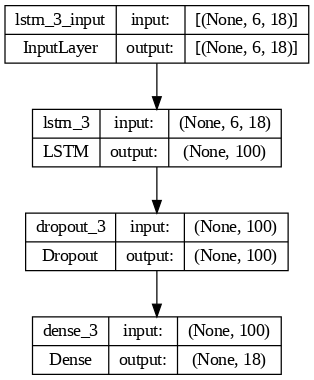

In [ ]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Saved_Model"
def create_LSTM_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005,var_num = 2,
                      hist_window=18,forecast_window=18):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(var_num,hist_window)))
    model.add(Dropout(.1))
    model.add(Dense(forecast_window))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model(LSTM_i=100, var_num=num_var)
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [ ]:
#Fit Model
print(datetime.datetime.now())
if train_b:
  model.fit(train, label_t, epochs=5, batch_size=16, verbose=2)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-03-12 20:52:51.927590
Epoch 1/5
32867/32867 - 180s - loss: 0.0146 - 180s/epoch - 5ms/step
Epoch 2/5
32867/32867 - 178s - loss: 0.0069 - 178s/epoch - 5ms/step
Epoch 3/5
32867/32867 - 182s - loss: 0.0061 - 182s/epoch - 6ms/step
Epoch 4/5
32867/32867 - 178s - loss: 0.0057 - 178s/epoch - 5ms/step
Epoch 5/5
32867/32867 - 177s - loss: 0.0054 - 177s/epoch - 5ms/step


3284/3284 [==============================] - 10s 3ms/step
[-0.81579524 -0.83620983 -0.85573405 -0.87411183 -0.8920228  -0.90911937
 -0.9290334  -0.9438977  -0.9588227  -0.97643304 -0.99126065 -1.005713
 -1.0230012  -1.039067   -1.0502669  -1.066727   -1.0765756  -1.0962567 ]
[-0.78038195 -0.82078251 -0.80479919 -0.83604317 -0.85086244 -0.86365741
 -0.86445288 -0.91841467 -0.91909681 -0.92802266 -0.91649575 -0.92989131
 -0.89900217 -0.98199776 -1.01240853 -1.0043729  -1.05084706 -1.03628642]
[4629.6816 4606.0483 4583.4453 4562.17   4541.4346 4521.642  4498.588
 4481.38   4464.1016 4443.7144 4426.549  4409.8174 4389.803  4371.204
 4358.2383 4339.1826 4327.7812 4304.9966]
[4670.679  4623.908  4642.4116 4606.241  4589.085  4574.2725 4573.3516
 4510.881  4510.0913 4499.758  4513.1025 4497.5947 4533.3545 4437.272
 4402.066  4411.3687 4357.5664 4374.423 ]
Total Test Score: 285.84 RMSE
90 Min Test Score: 97.05 RMSE
Relative Test Score: 1.67 perc RMSE


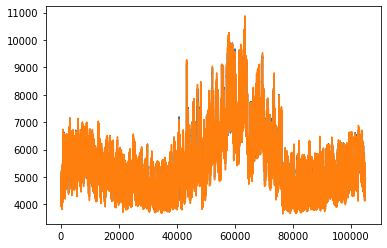

In [ ]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict(valid)


## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()

In [ ]:
ERROR_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Errors"

data_v = data.iloc[n-t:].shift(-forecast_window).reset_index(drop=True)
df_tv  = df_t.iloc[n-t:].shift(-forecast_window).reset_index(drop=True)

diff = [label_p_plot[i]-label_v_plot[i] for i in range(len(label_v_plot))]
m = min(diff)
pos = diff.index(m)

df_check = pd.DataFrame(zip(label_v_plot,label_p_plot,diff),columns = ['Actual','Predicted','Difference']  )
df_check = pd.concat([df_tv,data_v,df_check],axis=1)

#print(df_check.head(20).to_string())
tol_i = 500
m_i = df_check['Difference'] < -tol_i 

display_df = df_check[ m_i ].sort_values(by='Difference')
print(display_df.to_string())
print(sum(m_i))
print(round(100*float(sum(m_i))/float(t),2),'%')
print(sum(m_i))

#df_check.to_csv(f"{ERROR_DIR}/LSTM_90_minutes.csv")

               Time Stamp     N.Y.C.    Dni  HourlyDryBulbTemperature  Dni Future  HourlyDryBulbTemperature Future  Holiday_Weekend_B  Covid_B     Actual    Predicted  Difference
59224 2022-07-25 15:20:00  9393.6100    0.0                 77.416667       378.0                        82.951220                0.0      0.0  9393.6100  8633.219727 -760.390273
67872 2022-08-24 16:00:00  8651.1770  409.0                 84.000000         6.0                        80.350000                0.0      0.0  8651.1770  7899.880859 -751.296141
59223 2022-07-25 15:15:00  9399.4860    0.0                 77.000000        80.0                        82.707317                0.0      0.0  9399.4860  8648.243164 -751.242836
67873 2022-08-24 16:05:00  8643.6790  525.0                 83.705882        82.0                        80.266667                0.0      0.0  8643.6790  7903.244141 -740.434859
59222 2022-07-25 15:10:00  9405.9430    0.0                 76.583333         1.0                        

2.0 97.0
-760.3902734375006
801.18191796875


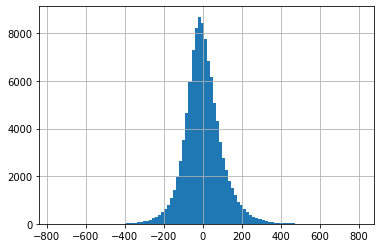

In [ ]:
d = df_check['Difference']
d.hist(bins=100)
print(round(d.mean(),1),round(d.std(),1))

print(d.min())
print(d.max())

<AxesSubplot:>

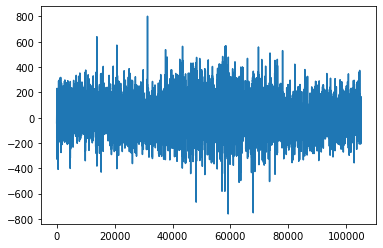

In [ ]:
d.plot.line()